# PPS DPG Lumi Plots

This Jupyter Notebook produces the usual integrated luminosity plots to show the data collected vs. time. 

## Get data from brilcalc

Run the following commands in lxplus.

### Setup brilcalc
```
source /cvmfs/cms-bril.cern.ch/cms-lumi-pog/brilws-docker/brilws-env
normtag=/cvmfs/cms-bril.cern.ch/cms-lumi-pog/Normtags/normtag_BRIL.json # preliminary normtag for Run3, use the approved one for physics!
```

### Choose your JSON

**CMS Golden JSON 2022:** 
```
json=/eos/user/c/cmsdqm/www/CAF/certification/Collisions22/Cert_Collisions2022_355100_362760_Golden.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/cms_2022.csv
```
**CMS Golden JSON 2023:** 
```
json=/eos/user/c/cmsdqm/www/CAF/certification/Collisions23/Cert_Collisions2023_366442_370790_Golden.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/cms_2023.csv
```
**PPS JSON 2023 (tracker):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2023/PPS-July2023_track_only.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track_only_2023.csv
```
**PPS JSON 2023 (tracker+timing):** 
```
json=/eos/project-c/ctpps/Operations/DataExternalConditions/2023/PPS-July2023_track+time.json
csv_output=/eos/home-${USER::1}/${USER}/SWAN_projects/pps-dpg-lumi-plots/pps_track+time_2023.csv
```

### Run brilcalc

For each json run:
```
brilcalc lumi --normtag $normtag -u /fb --byls --output-style csv -i $json -o $csv_output
```
Please mind the name of the csv files that are produced.

### Install packages you will need

In [ ]:
!pip install --user --upgrade matplotlib mplhep pandas

## Process the data

In [1]:
import pandas as pd
def fillDataFrame(csv_file):
    # Initialize empty lists for each column
    runs = []
    fills = []
    LSs = []
    dates = []
    del_lumis = []
    rec_lumis = []
    
    print('Parsing',csv_file+'...')
    # Open the CSV file for reading
    with open(csv_file, 'r') as file:
        # Iterate through each line in the file
        for line in file:
            # Check if the line does not start with '#'
            if not line.startswith('#'):
                # Split the line by commas
                parts = line.strip().split(',')

                # Extract the relevant information and append to the respective lists
                run_fill = parts[0].split(':')
                runs.append(int(run_fill[0]))
                fills.append(int(run_fill[1]))
                LSs.append(int(parts[1].split(':')[1]))
                dates.append(parts[2])
                del_lumis.append(float(parts[5]))
                rec_lumis.append(float(parts[6]))

    # Create a Pandas DataFrame from the lists
    df = pd.DataFrame({
        'run': runs,
        'fill': fills,
        'LS': LSs,
        'date': dates,
        'del_lumi': del_lumis,
        'rec_lumi': rec_lumis
    })

    # Add a cumulative sum column for del_lumi
    df['integrated_del_lumi'] = df['del_lumi'].cumsum()
    df['integrated_rec_lumi'] = df['rec_lumi'].cumsum()
    df['date'] = pd.to_datetime(df['date'])

    return df


In [2]:
cms_2023_csv = 'cms_2023.csv'
pps_2023_track_csv = 'pps_track_only_2023.csv'
pps_2023_tracktime_csv = 'pps_track+time_2023.csv'
cms_2023_df = fillDataFrame(cms_2023_csv)
pps_2023_track_df = fillDataFrame(pps_2023_track_csv)
pps_2023_tracktime_df = fillDataFrame(pps_2023_tracktime_csv)

Parsing cms_2023.csv...
Parsing pps_track_only_2023.csv...
Parsing pps_track+time_2023.csv...


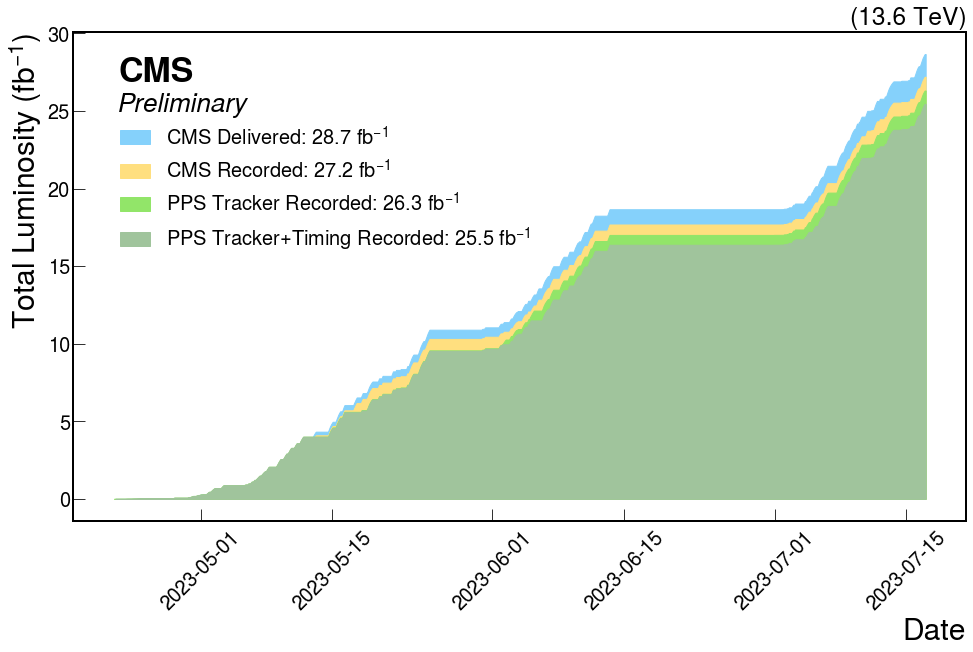

In [3]:
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use('CMS')

cms_tot_del = cms_2023_df['integrated_del_lumi'].iloc[-1]
cms_tot_rec = cms_2023_df['integrated_rec_lumi'].iloc[-1] 
pps_tot_track = pps_2023_track_df['integrated_rec_lumi'].iloc[-1]
pps_tot_tracktime = pps_2023_tracktime_df['integrated_rec_lumi'].iloc[-1]

# Create the XY plot with a filled area under the line
plt.figure(figsize=(16, 9))
plt.fill_between(cms_2023_df['date'], cms_2023_df['integrated_del_lumi'], color='#85d1fb', alpha=1, label=f'CMS Delivered: {cms_tot_del:.1f}'+' fb$^{-1}$')
plt.fill_between(cms_2023_df['date'], cms_2023_df['integrated_rec_lumi'], color='#ffdf7f', alpha=1, label=f'CMS Recorded: {cms_tot_rec:.1f}'+' fb$^{-1}$')
plt.fill_between(pps_2023_track_df['date'], pps_2023_track_df['integrated_rec_lumi'], color='#92e569', alpha=1, label=f'PPS Tracker Recorded: {pps_tot_track:.1f}'+' fb$^{-1}$')
plt.fill_between(pps_2023_tracktime_df['date'], pps_2023_tracktime_df['integrated_rec_lumi'], color='#a0c49c', alpha=1, label=f'PPS Tracker+Timing Recorded: {pps_tot_tracktime:.1f}'+' fb$^{-1}$')
plt.xlabel('Date',fontsize=30)
plt.ylabel('Total Luminosity (fb$^{-1}$)',fontsize=30)
plt.xticks(rotation=45,fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left', fontsize=20, bbox_to_anchor=(0.03,0.85))

# Remove minor ticks (which don't really make sense here)
plt.minorticks_off()

# Remove right and top axis. It's not CMS-style, I know, but they're really ugly and useless in this case
plt.tick_params(axis='both', which='both', direction='in', top=False, right=False)

# Add CMS Preliminary label
hep.cms.label('Preliminary',loc=2, data=True, rlabel='(13.6 TeV)')

# Show the plot
plt.show()